## Improting Required libraries

In [7]:
import mne
import matplotlib.pyplot as plt
import glob
import numpy as np

In [8]:
mne.viz.set_browser_backend("matplotlib")

'matplotlib'

## Enabling CUDA use for MNE

In [9]:
mne.utils.set_config('MNE_USE_CUDA', 'true')

## Reading Dataset
We are reading four different kinds of datasets depicting 
- Heartfulness Meditation (htr)
- Concentration Meditation (ctr)
- Vipassana Meditation (vip)
- Sahaja Yoga Meditation (sny)

respectively.

In [10]:
%%capture
# To avoid unneccesary writing

raw_data  =[]

# Types of data (for task-wise analysis)
data_we_need = ['015', '026', '062', '080']

# Getting data for task-wise analysis
for subject_number in data_we_need:
    for file in sorted(glob.glob('../sub-'+subject_number+'/eeg/*.bdf')):
        try:            
            data = mne.io.read_raw_bdf(file, preload=True)
            times = data.times
            duration = times[-1] - times[0]
            # Getting only data greater than or equal to 10 minutes
            if duration >= 600:
                raw_data.append(data)
        except:
            print(file +" not loaded")

med1 = [0, 4, 8, 12]
med2 = [1, 5, 9, 13]
think1 = [2, 6, 10, 14]
think2 = [3, 7, 11, 15]

## Preprocessing Data
In this process, we will extract the necessary duration of data required and perform data cleaning to remove any artifacts.
- Referencing Data
- Dropping unnecessary channels
- Cropping data
- Filtering data (notch filter and bandpass filter)
- Applying ICA

In [11]:
%%capture

# Referencing data (To apply_inverse for source localization)
raw_data  = [data.set_eeg_reference(projection=True) for data in raw_data]

In [12]:
# Dropping Channels
raw_data = [data.drop_channels(['EXG1', 'EXG2', 'EXG3', 'EXG4',
        'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']) for data in raw_data]

In [13]:
# Croping Data 
# Considering only first 10 minutes
cropped_raw_data = []

for files in raw_data:
    cropped_raw_data.append(files.crop(tmin=0.0, tmax=600.0))

### Downsampling data

In [14]:
%%capture

# Downsampling data to 256 Hz
raw_resampled = [raw_data.copy().resample(sfreq=256, npad="auto", n_jobs="cuda") for raw_data in cropped_raw_data]

In [15]:
# Preprocessing
# Cleaning the entire EEG 
def get_filtered_eeg(raw):
    low_freq = 0.3
    high_freq = 100.0

    raw_filtered = raw.copy().notch_filter(freqs=50)

    # Apply the bandpass filter
    raw_filtered = raw_filtered.filter(l_freq=low_freq, h_freq=high_freq, fir_design='firwin', n_jobs="cuda")

    #ASR cleaning with cutoff=20
    # asr = asrpy.ASR(sfreq=raw.info["sfreq"], cutoff=20)
    # asr.fit(raw_filtered)
    # raw_filtered = asr.transform(raw_filtered)

    ica = mne.preprocessing.ICA(n_components=15, max_iter="auto", random_state=97)
    ica.fit(raw_filtered)

    # # ica.plot_components()

    ica.exclude = []
    # find which ICs match the EOG pattern; no EOG attached, Taking Fp1 as proxy
    eog_indices, eog_scores = ica.find_bads_eog(raw_filtered,ch_name="Fp1")
    ica.exclude = eog_indices
    ica.apply(raw_filtered)
    return raw_filtered

In [16]:
# Channels
np.array(raw_data[0].ch_names).reshape(1, 64)

array([['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3',
        'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1',
        'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz',
        'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4',
        'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4',
        'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8',
        'P10', 'PO8', 'PO4', 'O2']], dtype='<U3')

In [17]:
%%capture

# Filtering data
filtered_data = []

for data in raw_resampled:
    filtered_data.append(get_filtered_eeg(data))

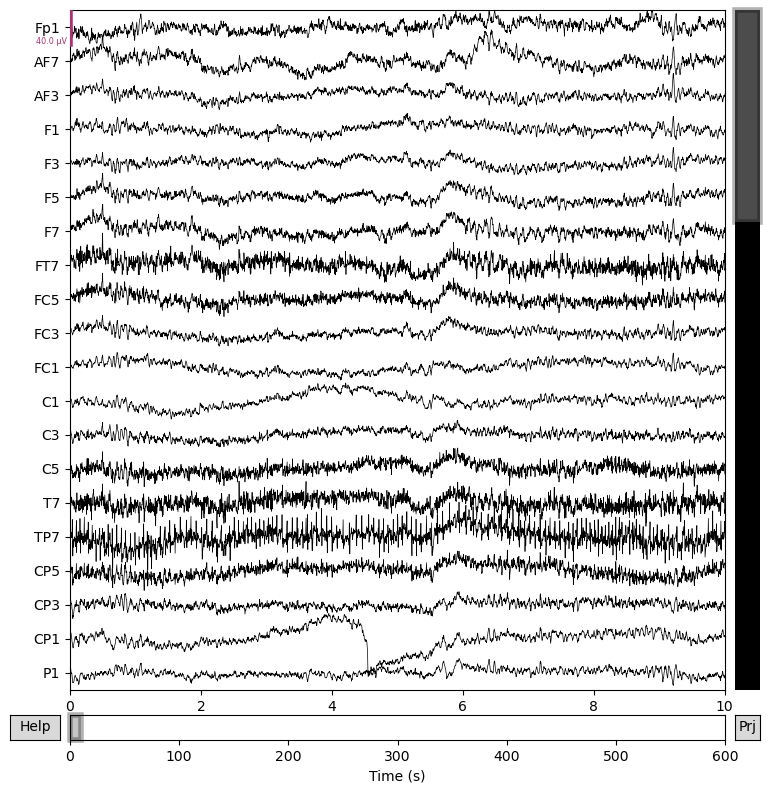

In [18]:
filtered_data[0].plot();

Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_2468251/2036467727.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  filtered_data[0].compute_psd().plot(picks="data", exclude="bads", amplitude=False)


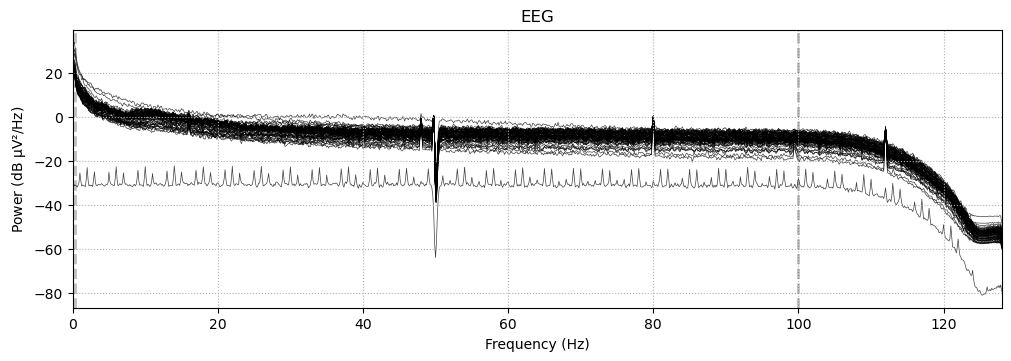

In [19]:
filtered_data[0].compute_psd().plot(picks="data", exclude="bads", amplitude=False)

## Power Spectral Density(PSD)

In [20]:
%%capture

# Computing PSD data for whole mediation 1 data
psdDatas, psdFreqs = [],  []
for i in med1:
    psdData, psdFreq = filtered_data[i].compute_psd(fmin=2, fmax=110, picks=['Oz']).get_data(return_freqs = True)
    psdDatas.append(psdData)
    psdFreqs.append(psdFreq)

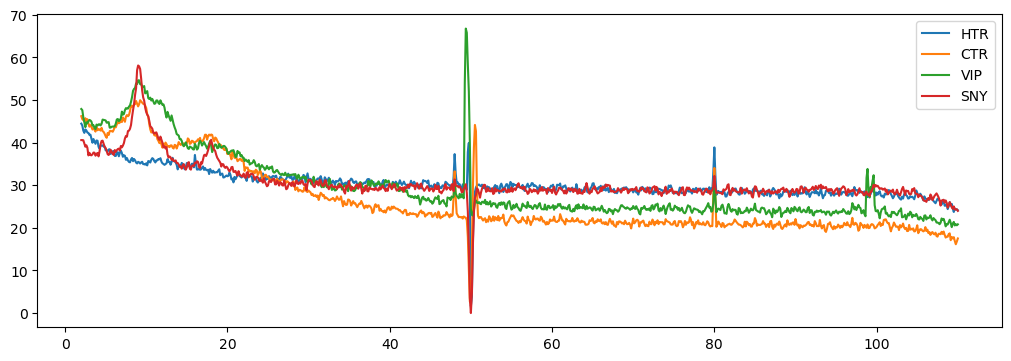

In [21]:
plt.clf()

# To get whole positive graph
shift_med1 = np.min([np.min(10*np.log10(psdDatas[0][0])), np.min(10*np.log10(psdDatas[1][0])), np.min(10*np.log10(psdDatas[2][0])), np.min(10*np.log10(psdDatas[3][0]))])

# Plotting all plots
# Converting to dB and referencing for positive graph
plt.plot(psdFreq, 10*np.log10(psdDatas[0][0]) - shift_med1);
plt.plot(psdFreq, 10*np.log10(psdDatas[1][0]) - shift_med1);
plt.plot(psdFreq, 10*np.log10(psdDatas[2][0]) - shift_med1);
plt.plot(psdFreq, 10*np.log10(psdDatas[3][0]) - shift_med1);
plt.legend([
    'HTR',
    'CTR',
    'VIP',
    'SNY'
])
plt.show();

## Removing pink noise
In this section, we will remove 1/f or pink or fatal noise from our data

In [22]:
def power_law(x, a, b):
    return a * (x ** (-b))

<Figure size 640x480 with 0 Axes>

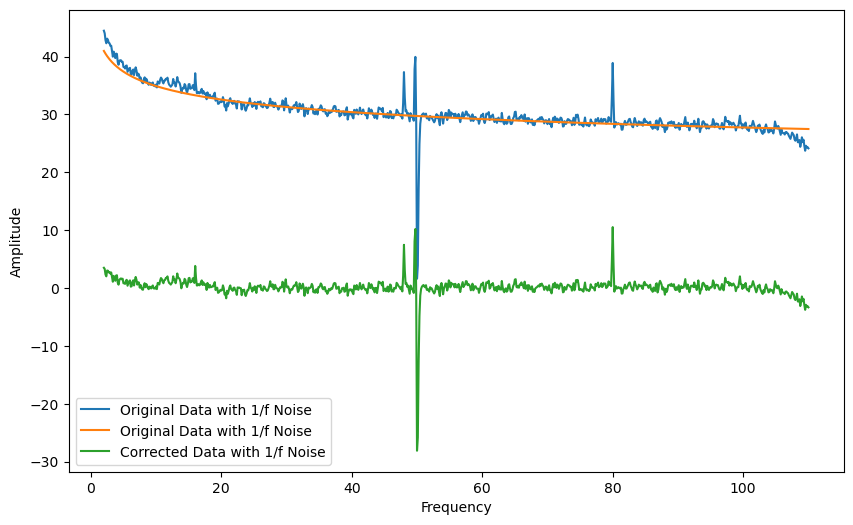

In [23]:
from scipy.optimize import curve_fit

# Select the tail region for fitting
tail_fraction = 0.6
tail_start_index = int((1 - tail_fraction) * len(psdFreqs[0]))

# Getting tail
x_tail = psdFreqs[0][tail_start_index:]
y_tail = (10*np.log10(psdDatas[0][0]) - shift_med1)[tail_start_index:]

# Fitting a curve to tail
popt, _ = curve_fit(power_law, x_tail, y_tail)
a, b = popt

y_fit = power_law(psdFreqs[0], a, b)

# # Plot the fitted curve on top of the original data
plt.clf()
plt.figure(figsize=(10, 6))
plt.plot(psdFreq, 10*np.log10(psdDatas[0][0]) - shift_med1, label='Original Data with 1/f Noise');
plt.plot(psdFreq, y_fit, label='Original Data with 1/f Noise');
plt.plot(psdFreq, 10*np.log10(psdDatas[0][0]) - shift_med1 - y_fit, label='Corrected Data with 1/f Noise');
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.legend()
plt.show();


## Ploting power spectrum

<Figure size 640x480 with 0 Axes>

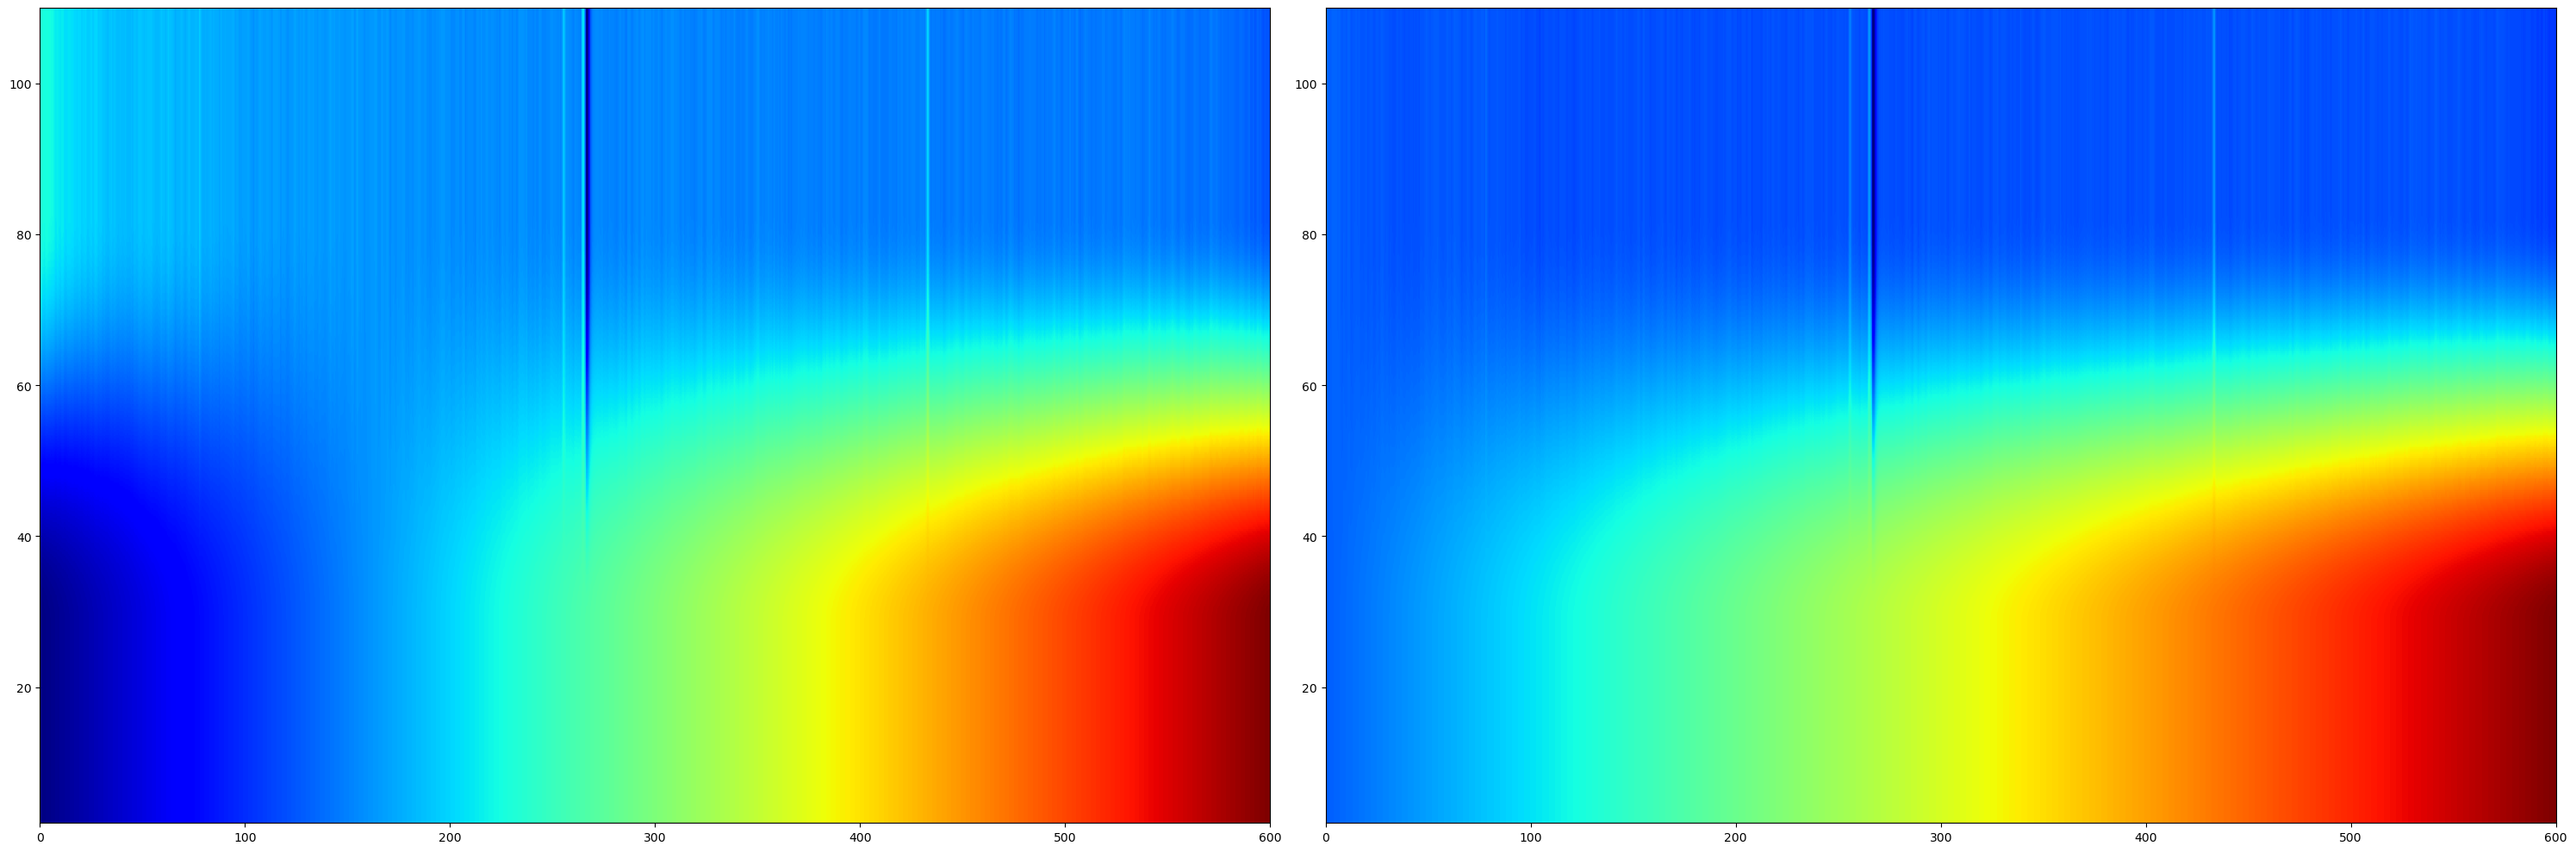

In [24]:
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10));
im1 = ax1.imshow((psdFreqs[0], (10*np.log10(psdDatas[0][0]) - shift_med1)),origin='lower', aspect='auto', extent=[0, 600, 2, 110], cmap='jet');
im2 = ax2.imshow((psdFreqs[0], 10*np.log10(psdDatas[0][0]) - shift_med1 - y_fit),origin='lower', aspect='auto', extent=[0, 600, 2, 110], cmap='jet');
plt.tight_layout()
plt.show()

## Connectivity

In [25]:
from mne_connectivity import spectral_connectivity_epochs

Creating fake epochs

In [26]:
# Define parameters
epoch_length = 10.0  # in seconds
overlap = 0.5  # in seconds
sfreq = filtered_data[0].info['sfreq']  # sampling frequency
epoch_samples = int(epoch_length * sfreq)
overlap_samples = int(overlap * sfreq)

# Calculate the number of epochs
n_epochs = int((len(filtered_data[0]) - overlap_samples) / (epoch_samples - overlap_samples))

# Generate events
events = np.array([[i * (epoch_samples - overlap_samples), 0, 1] for i in range(n_epochs)])

In [27]:
%%capture

# Create epochs
epochs = [mne.Epochs(data, events, event_id=1, tmin=0, tmax=epoch_length, baseline=None, preload=True) for data in filtered_data]

In [28]:
np.array(epochs[0]).shape

(63, 64, 2561)

<Figure size 640x480 with 0 Axes>

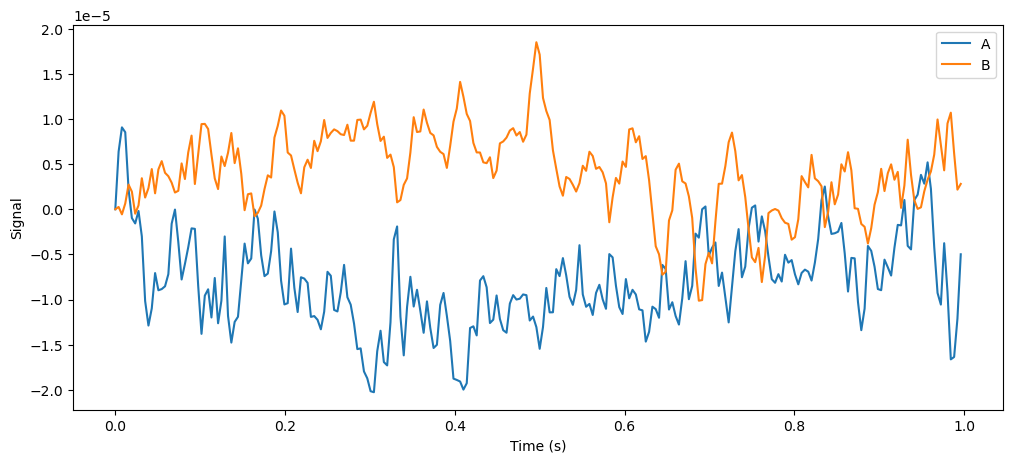

In [29]:
fs = 256

t = np.arange(0, epoch_length, 1 / fs)

plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(12, 5), sharey=True)
ax.plot(t[:fs], np.array(epochs[0])[0, 0, :fs], label="A");
ax.plot(t[:fs], np.array(epochs[0])[0, 2, :fs], label="B");

ax.set_xlabel("Time (s)")
ax.set_ylabel("Signal")
ax.legend()

plt.show();

In [30]:
# Frequecy bands of interest (broad sense)
Freq_bands = {"theta": [4.0, 8.0], "alpha": [8.0, 13.0], "beta": [13.0, 30.0]}
n_freq_bands = len(Freq_bands)
min_freq = np.min(list(Freq_bands.values()))
max_freq = np.max(list(Freq_bands.values()))

In [31]:
# Freq points (Freqs of interest with higher resolution on which cwt will apply)
freqs = np.linspace(min_freq, max_freq, int((max_freq - min_freq)) * 4 + 1)
freqs

array([ 4.  ,  4.25,  4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,
        6.25,  6.5 ,  6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,
        8.5 ,  8.75,  9.  ,  9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 ,
       10.75, 11.  , 11.25, 11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75,
       13.  , 13.25, 13.5 , 13.75, 14.  , 14.25, 14.5 , 14.75, 15.  ,
       15.25, 15.5 , 15.75, 16.  , 16.25, 16.5 , 16.75, 17.  , 17.25,
       17.5 , 17.75, 18.  , 18.25, 18.5 , 18.75, 19.  , 19.25, 19.5 ,
       19.75, 20.  , 20.25, 20.5 , 20.75, 21.  , 21.25, 21.5 , 21.75,
       22.  , 22.25, 22.5 , 22.75, 23.  , 23.25, 23.5 , 23.75, 24.  ,
       24.25, 24.5 , 24.75, 25.  , 25.25, 25.5 , 25.75, 26.  , 26.25,
       26.5 , 26.75, 27.  , 27.25, 27.5 , 27.75, 28.  , 28.25, 28.5 ,
       28.75, 29.  , 29.25, 29.5 , 29.75, 30.  ])

In [32]:
# Getting minimum frequecy for each band
fmin = tuple([list(Freq_bands.values())[i][0] for i in range(n_freq_bands)])
fmax = tuple([list(Freq_bands.values())[f][1] for f in range(len(Freq_bands))])

In [33]:
# Connectivity methods
# Allocate memory for connectivity matrices
con_matrix = np.zeros((
    len(raw_data[0].ch_names), len(raw_data[0].ch_names), n_freq_bands, np.array(epochs[0]).shape[2]
))
# nan matrix
con_matrix [con_matrix == 0] = np.nan

In [34]:
fmin, fmax

((4.0, 8.0, 13.0), (8.0, 13.0, 30.0))

In [35]:
epochs[0]

Number of events,63
Events,1: 63
Time range,0.000 – 10.000 s
Baseline,off


In [36]:
# Applying coherence method using cwt_morlet over freqs

conn_epochs = spectral_connectivity_epochs(
    epochs[0], method='coh', mode='cwt_morlet', sfreq=256, cwt_freqs=freqs, fmin=fmin, fmax=fmax, faverage=True)

Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2016 connections
    using t=0.000s..10.000s for estimation (2561 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..8.0Hz (17 points)
     band 2: 8.0Hz..13.0Hz (21 points)
     band 3: 13.0Hz..30.0Hz (69 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spect

In [37]:
conn_epochs

<SpectroTemporalConnectivity | freq : [6.000000, 21.500000], time : [0.000000, 10.000000], , nave : 63, nodes, n_estimated : 64, 4096, ~240.2 MB>

In [38]:
# Get data as connectivity matrices
con_matrix = conn_epochs.get_data(output="dense")
# Connections between 64 electrodes in 3 frequencies of interest in 2561 timepoints (timepoint in each epoch)
con_matrix.shape

(64, 64, 3, 2561)

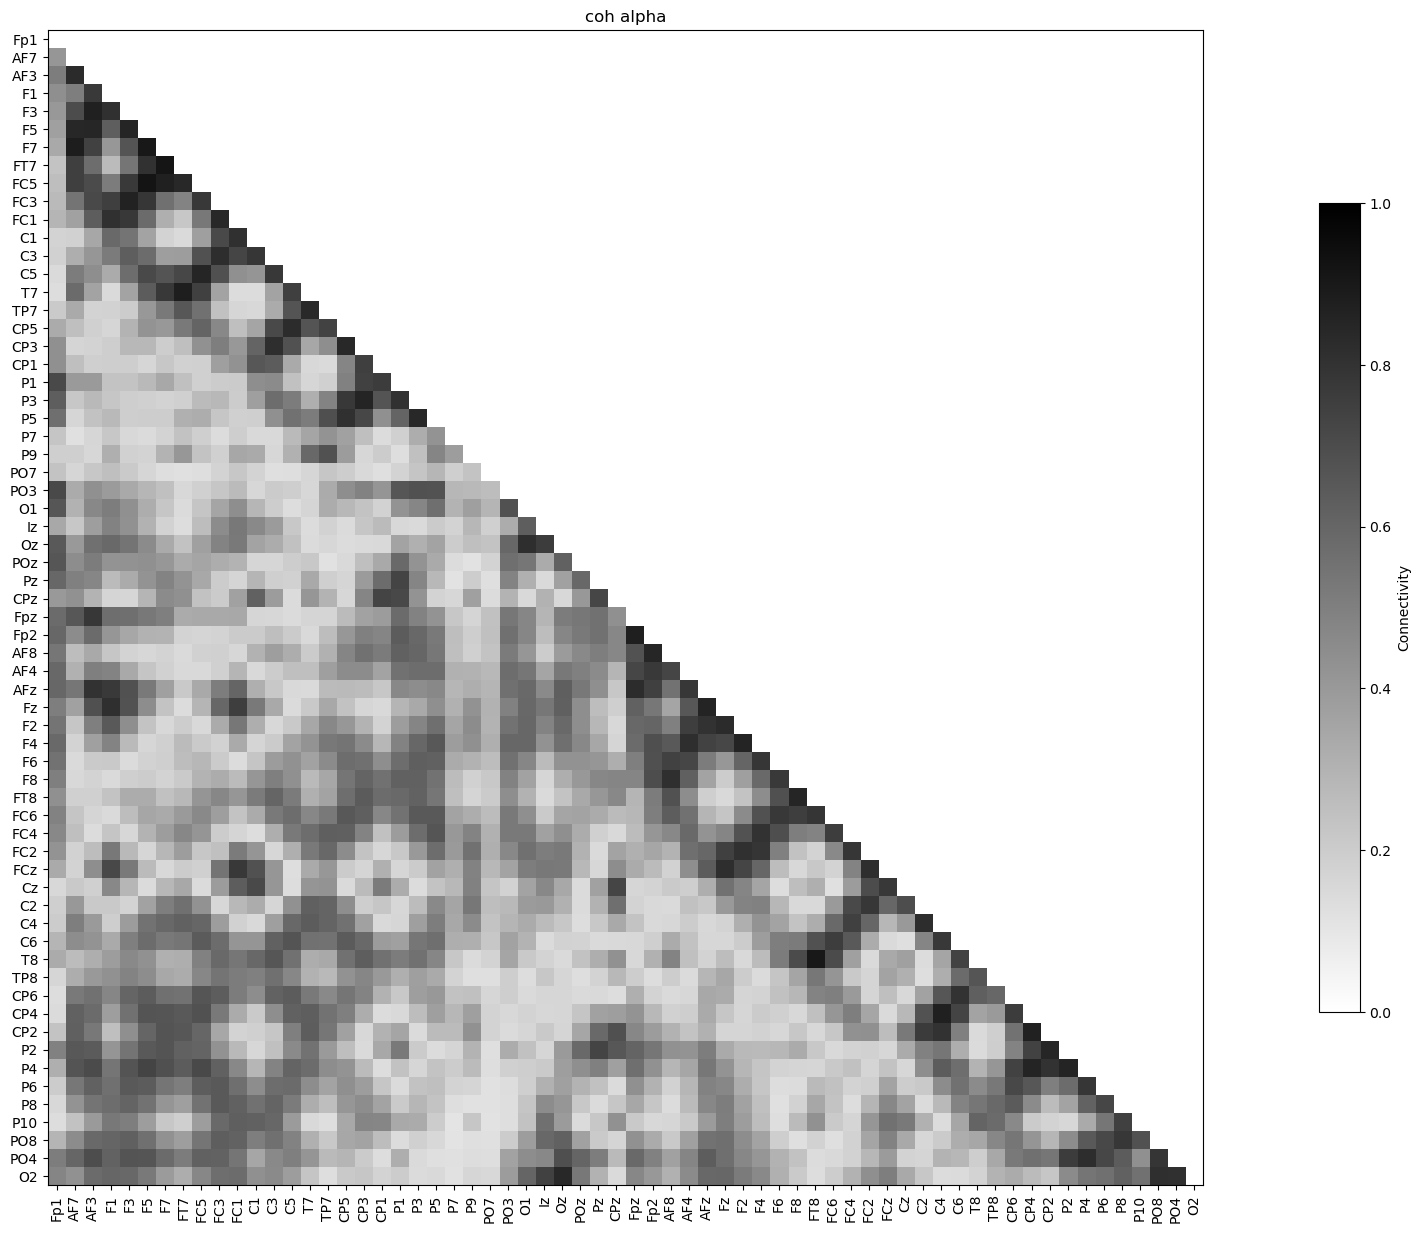

In [39]:
# Averaging over timepoints
con_epochs_array = np.mean(con_matrix, axis=3)

# Just alpha band
foi = list(Freq_bands.keys()).index("alpha")


# Define function for plotting con matrices
def plot_con_matrix(con_data):
    fig, ax = plt.subplots(1, 1, figsize=(30, 15))
    con_plot = ax.imshow(con_data[:, :, foi], cmap="binary", vmin=0, vmax=1)
    ax.set_title('coh alpha')
    # Add colorbar
    fig.colorbar(con_plot, ax=ax, shrink=0.7, label="Connectivity")
    # Fix labels
    ax.set_xticks(range(len(raw_data[0].ch_names)))
    ax.set_xticklabels(raw_data[0].ch_names, rotation=90)
    ax.set_yticks(range(len(raw_data[0].ch_names)))
    ax.set_yticklabels(raw_data[0].ch_names)
    return fig


plot_con_matrix(con_epochs_array)

As connectivity between i and j is same as between j and i, therefore only one half of matrix populated

##### Method: Maximised Imaginary part of Coherency (MIC)
This method is raliable as imaginary part of coherency is least affected by volume coduction or field spread. Maximizing it helps to emphasize connections that are likely to represent true physiological interactions rather than artifacts

In [40]:
# Canonical Coherence based connectivity

# Channel indices to see connectivity between these
seeds = [0, 1, 2, 6, 7, 8]
targets = [3, 4, 5, 9, 10, 11]
# Indices for multivariante connectivity
multivar_indices = ([seeds], [targets])

# Compute MIC
mic = spectral_connectivity_epochs(
    epochs[0], method="mic", indices=multivar_indices, sfreq=256, fmin=fmin, fmax=fmax
)


Replacing existing metadata with 3 columns
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..10.000s for estimation (2561 points)
    computing connectivity for the bands:
     band 1: 4.1Hz..8.0Hz (40 points)
     band 2: 8.1Hz..13.0Hz (50 points)
     band 3: 13.1Hz..30.0Hz (170 points)
Estimated data ranks:
    connection 1 - seeds (6); targets (6)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: MIC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
   

In [41]:
# Multivariante connectivity between all the channels at {40 (theta) + 50 (beta) + 170 (gamma) points}
mic.shape

(1, 260)

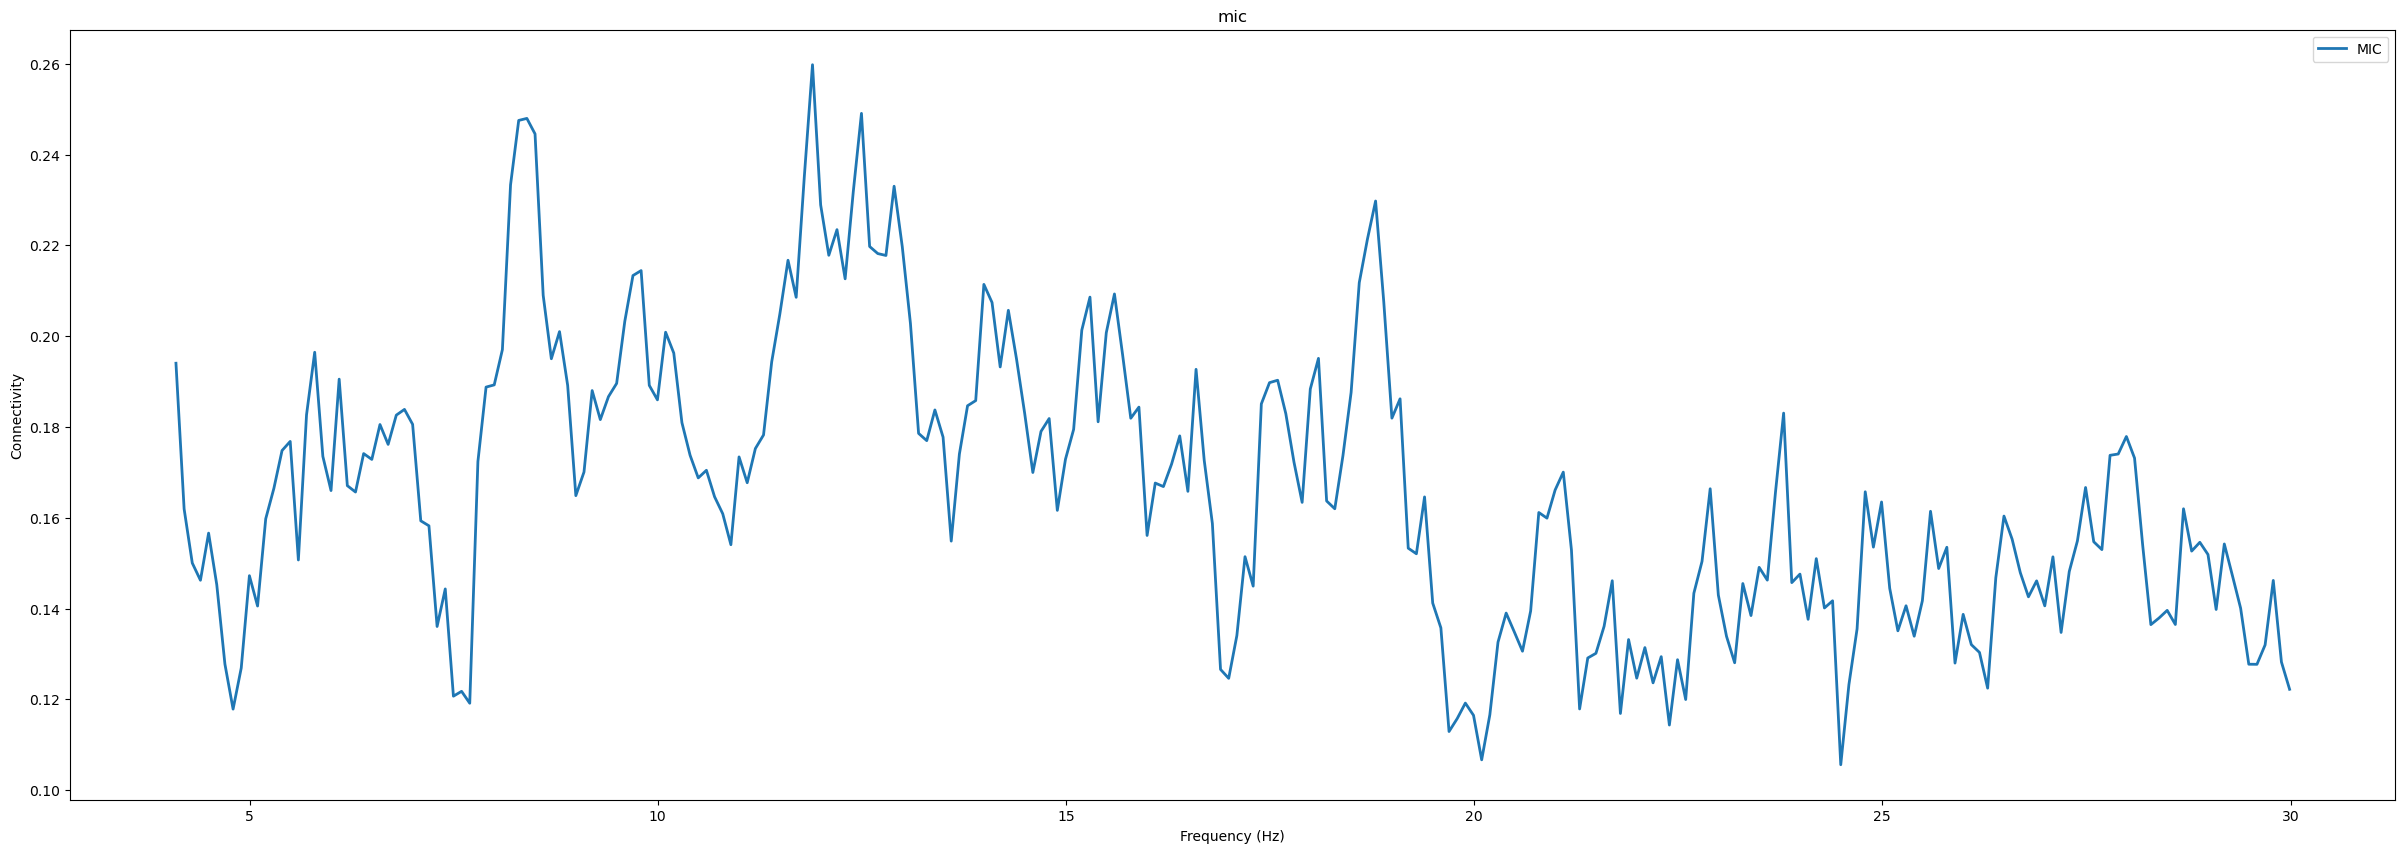

In [52]:
fig, axis = plt.subplots(1, 1, figsize=(30, 10))
axis.plot(
    mic.freqs, np.abs(mic.get_data()[0]), linewidth=2, label="MIC"
);

axis.set_title('mic')
axis.set_xlabel("Frequency (Hz)");
axis.set_ylabel("Connectivity");
axis.legend()
plt.show();

    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 64 -> 62
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 63
[done]
Computing rank from covariance with rank=None
    Using tolerance 1.2e-13 (2.2e-16 eps * 64 dim * 8.2  max singular value)
    Estimated rank (eeg): 62
    EEG: rank 62 computed from 64 data channels with 0 projectors


/tmp/ipykernel_2468251/1311693985.py:2: RuntimeWarning: Epochs are not baseline corrected, covariance matrix may be inaccurate
  noise_cov = mne.compute_covariance(epochs[0], tmax=0., method='empirical')
/tmp/ipykernel_2468251/1311693985.py:2: RuntimeWarning: Too few samples (required : 325 got : 63), covariance estimate may be unreliable
  noise_cov = mne.compute_covariance(epochs[0], tmax=0., method='empirical')


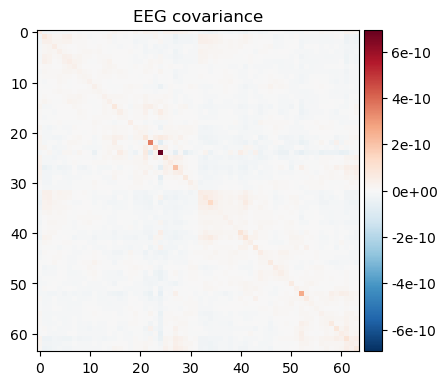

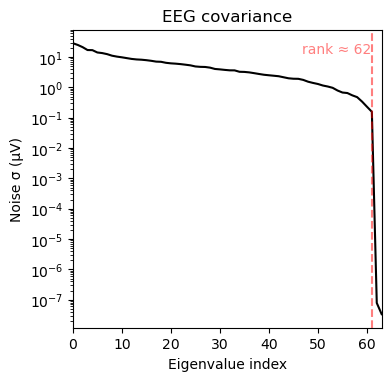

In [43]:
# Computing noise covariance matrix from the epochs
noise_cov = mne.compute_covariance(epochs[0], tmax=0., method='empirical')
noise_cov.plot(filtered_data[0].info);

In [44]:
# Use standard head model
import os.path as op
from mne.datasets import fetch_fsaverage

# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)

# The files
subject = "fsaverage"
trans = "fsaverage"
src = op.join(fs_dir, "bem", "fsaverage-ico-5-src.fif")
bem = op.join(fs_dir, "bem", "fsaverage-5120-5120-5120-bem-sol.fif")

0 files missing from root.txt in /home/server/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /home/server/mne_data/MNE-fsaverage-data/fsaverage


In [45]:
# Set standard montage to assign EEG locations
montage = mne.channels.make_standard_montage('standard_1005')
filtered_data[0].set_montage(montage)

# Compute forward solution
fwd = mne.make_forward_solution(
    filtered_data[0].info, trans=trans, src=src, bem=bem, eeg=True, mindist=5.0, n_jobs=None
)
print(fwd)

Source space          : /home/server/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /home/server/anaconda3/envs/eeg_env_1/lib/python3.12/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /home/server/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /home/server/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999994 0.003552 0.000202      -1.76 mm
    -0.003558 0.998389 0.056626      31.09 mm
    -0.000001 -0.056626 0.998395      39.60 mm
    0.000000 0.000000 0.000000       1.00

Read  64 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Setting up the BEM 

In [46]:
subject = mne.datasets.fetch_infant_template("6mo", subjects_dir, verbose=True)

# BEM and source spaces
bem_dir = op.join(subjects_dir, subject, "bem")
fname_src = op.join(bem_dir, f"{subject}-oct-6-src.fif")

src = mne.read_source_spaces(fname_src)
print(src)
fname_bem = op.join(bem_dir, f"{subject}-5120-5120-5120-bem-sol.fif")
bem = mne.read_bem_solution(fname_bem)

0 files missing from ANTS6-0Months3T.txt in /home/server/mne_data/MNE-fsaverage-data/ANTS6-0Months3T
    Reading a source space...
    Distance information added...
    [done]
    Reading a source space...
    Distance information added...
    [done]
    2 source spaces read
<SourceSpaces: [<surface (lh), n_vertices=48640, n_used=4098>, <surface (rh), n_vertices=48214, n_used=4098>] MRI (surface RAS) coords, subject 'ANTS6-0Months3T', ~6.9 MB>
Loading surfaces...

Loading the solution matrix...

Three-layer model surfaces loaded.
Loaded linear collocation BEM solution from /home/server/mne_data/MNE-fsaverage-data/ANTS6-0Months3T/bem/ANTS6-0Months3T-5120-5120-5120-bem-sol.fif


In [47]:
# Computing inverse operator
inverse_operator = mne.minimum_norm.make_inverse_operator(filtered_data[0].info, fwd, noise_cov, loose=0.2, depth=0.8)

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 64 channels.
    64 out of 64 channels remain after picking
Selected 64 channels
Creating the depth weighting matrix...
    64 EEG channels
    limit = 20485/20484 = 2.187745
    scale = 124915 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 1.2e-13 (2.2e-16 eps * 64 dim * 8.2  max singular value)
    Estimated rank (eeg): 62
    EEG: rank 62 computed from 64 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of 

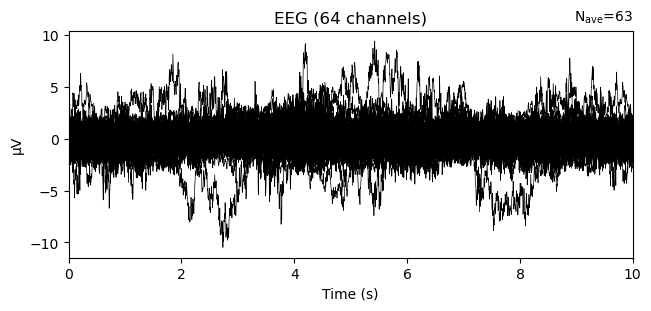

In [48]:
evoked = epochs[0].average().pick("eeg");
evoked.plot(time_unit="s");

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Computing rank from covariance with rank=None
    Using tolerance 1.2e-13 (2.2e-16 eps * 64 dim * 8.2  max singular value)
    Estimated rank (eeg): 62
    EEG: rank 62 computed from 64 data channels with 1 projector
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank={'eeg': 62}
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 62 (2 small eigenvalues omitted)


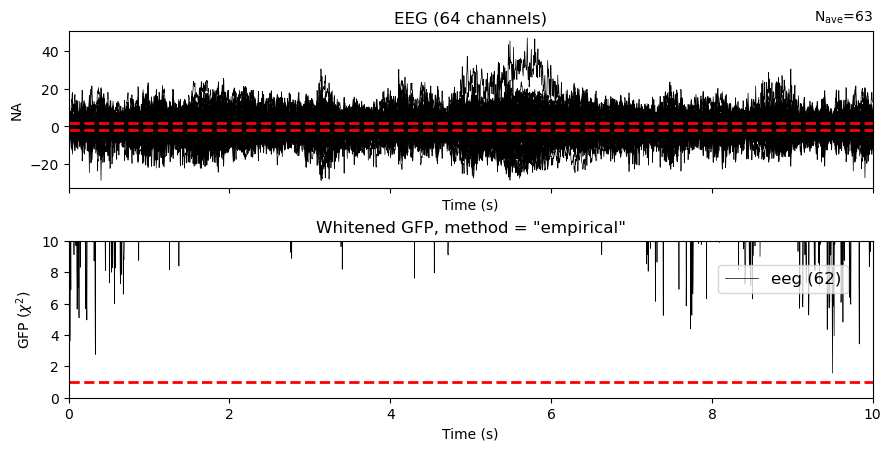

In [49]:
evoked.plot_white(noise_cov, time_unit="s");

In [56]:
method = "dSPM"
snr = 3.0
lambda2 = 1.0 / snr**2
# Compute inverse solution and for each epoch
stcs = mne.minimum_norm.apply_inverse_epochs(
    epochs[0], inverse_operator, lambda2, method, pick_ori="normal", return_generator=True
)

In [58]:
# Get labels (anatomical regions defined on cortical surface of brain) for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
labels = mne.read_labels_from_annot("fsaverage", parc="aparc", subjects_dir=subjects_dir)
label_colors = [label.color for label in labels]

# Average the source estimates within each label using sign-flips to reduce
# signal cancellations, also here we return a generator
src = inverse_operator["src"]
label_ts = mne.extract_label_time_course(
    stcs, labels, src, mode="mean_flip", return_generator=True
)


Reading labels from parcellation...
   read 35 labels from /home/server/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 34 labels from /home/server/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
